# Applying EBMs to the CIFAR-10 dataset

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import scipy
import sklearn
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
from sgld_sampler import sgld_sample
from EBM import EBM
from wrn import create_wide_residual_network
from scores import inception_score, frechet_inception_distance

In [3]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_train_full.shape, y_train_full.shape

((50000, 32, 32, 3), (50000, 1))

In [4]:
classifier_model = create_wide_residual_network((32,32,3), nb_classes=10, N=4, k=8)
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 128)  18432       activation[0][0]                 
______________________________________________________________________________________________

In [ ]:
classifier_model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer="adam", metrics=["accuracy"])
early_stopping = keras.callbacks.EarlyStopping(patience=5, 
                                               restore_best_weights=True)
history = classifier_model.fit(X_train_full, y_train_full, epochs=7,
                               validation_split=0.2,
                               callbacks=[early_stopping])

In [122]:
classifier_model.save_weights('class-1')

In [5]:
classifier_model.load_weights('class-1')

In [16]:
def fuse_images(width, height, images, img_width, img_height, n_channels=3):
    really_big_image = None
    for i in range(width):
        big_image = None
        for j in range(height):
            cur_image = images[width * i + j].reshape(img_width, img_height, n_channels)
            if big_image is not None:
                big_image = np.hstack((big_image, cur_image))
            else:
                big_image = cur_image
        if really_big_image is not None:
            really_big_image = np.vstack((really_big_image, big_image))
        else:
            really_big_image = big_image
    return really_big_image

def is_metric_callback(samples_data, samples_energ, it):
    p_yx = tf.nn.softmax(classifier_model(samples_energ)).numpy()
    score = inception_score(p_yx)
    if it == 0:
        imgs = np.array(samples_energ)
        imgs = np.clip(imgs, 0, 1)
        img = fuse_images(10, 10, imgs, 32, 32)
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.colorbar()
        plt.show()
    return score

# Need last-layer activations for FID
cifar_statistics = keras.Model(classifier_model.input, classifier_model.get_layer(name='flatten').output)

def fid_metric_callback(samples_data, samples_energ, it):
    stats_gen = cifar_statistics(samples_energ)
    stats_real = cifar_statistics(samples_data)
    score = frechet_inception_distance(stats_real, stats_gen)
    return -score

In [4]:
ebm_model = create_wide_residual_network((32,32,3), nb_classes=1, N=4, k=9)
ebm_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   432         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 144)  20736       activation[0][0]                 
______________________________________________________________________________________________

In [5]:
lr = 1e-4
optimizer = keras.optimizers.Adam(lr)
ebm = EBM(ebm_model, optimizer)
batch_size = 128
step_size = 15
num_epochs = 25

In [ ]:
history = ebm.fit(X_train_full, batch_size, num_epochs, optimizer, 0.0, 1.0, num_steps_markov=tf.constant(60),
            var=tf.constant(0.005 ** 2), step_size=step_size, callbacks_energy=[],
            metrics_samples=[("IS", is_metric_callback), ("FID", fid_metric_callback)],
            alpha=1.0, clip_thresh=tf.constant(0.01), save_best_weights=True, early_stopping=False,
            uniform_chance=0.05)

In [14]:
imgs = np.array(ebm.replay_buffer)

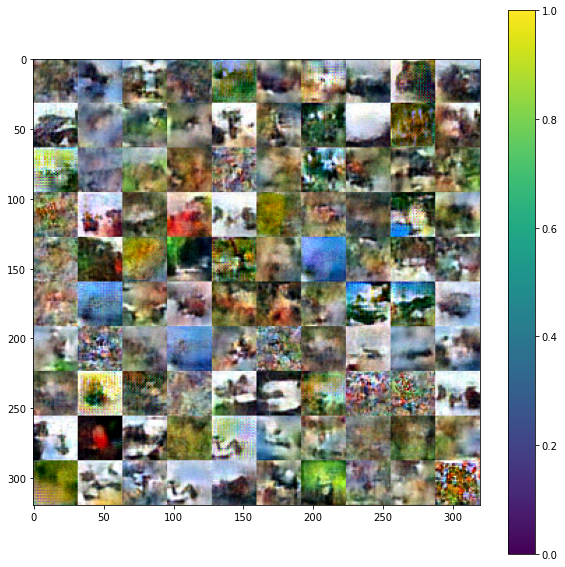

In [15]:
img = fuse_images(10, 10, imgs, 32, 32)
img = np.clip(img, 0, 1)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.colorbar()
plt.show()